In [1]:
# This module trains a GRU model for the prediction of wind speed
# and prints the error metrics

import pandas as pd
import numpy as np

from prophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

from PyEMD import CEEMDAN

import matplotlib.pyplot as plt
%matplotlib notebook

from tensorflow import keras
from tensorflow.keras.utils import plot_model

from prophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot

In [2]:
#function for printing the metrics of the predictions
def print_metrics(pred, y_vals):
    print('mape: ', metrics.mean_absolute_percentage_error(y_vals, pred))
    print('mae: ', metrics.mean_absolute_error(y_vals, pred))
    print('mse: ', metrics.mean_squared_error(y_vals, pred))
    print('rmse: ', np.sqrt(metrics.mean_squared_error(y_vals, pred)))
    print('score: ', metrics.r2_score(y_vals, pred))
    count = 0
    y_error = pred.flatten() - y_vals.flatten()
    y_error = np.array([abs(e) for e in y_error]).flatten()

    # accuracy calculation(number of predictions having less than 20% error)
    for i in range(len(y_error)):
        if(y_error[i] < 0.20 * y_test[i]):
            count += 1
    print('accuracy: ', count / len(pred))

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.describe().round()

,lrad,prec,pres,shum,srad,temp,wind
count,5840.0,5840.0,5840.0,5840.0,5840.0,5840.0,5840.0
mean,269.0,0.0,85521.0,0.0,193.0,281.0,4.0
std,65.0,0.0,611.0,0.0,268.0,14.0,2.0
min,132.0,0.0,83722.0,0.0,0.0,246.0,0.0
25%,216.0,0.0,85050.0,0.0,0.0,270.0,2.0
50%,266.0,0.0,85520.0,0.0,3.0,283.0,4.0
75%,321.0,0.0,85974.0,0.0,352.0,293.0,5.0
max,450.0,3.0,86820.0,0.0,990.0,311.0,16.0


In [5]:
y = data[["wind"]][1:]

In [6]:
IImfs=[]
def ceemdan_decompose_res(data):
    ceemdan = CEEMDAN()
    ceemdan.ceemdan(data)
    imfs, res = ceemdan.get_imfs_and_residue()
    plt.figure(figsize=(12,9))
    plt.subplots_adjust(hspace=0.1)
    plt.subplot(imfs.shape[0]+3, 1, 1)
    plt.plot(data,'r')
    for i in range(imfs.shape[0]):
        plt.subplot(imfs.shape[0]+3,1,i+2)
        plt.plot(imfs[i], 'g')
        plt.ylabel("IMF %i" %(i+1))
        plt.locator_params(axis='x', nbins=10)
        # 在函数前必须设置一个全局变量 IImfs=[]
        IImfs.append(imfs[i])
    plt.subplot(imfs.shape[0]+3, 1, imfs.shape[0]+3)
    plt.plot(res,'g')
    return res

In [7]:
# for item in ["lrad", "prec", "pres", "srad", "temp", "wind"]:
#     res=ceemdan_decompose_res(data[item].to_numpy().ravel())
#     IImfs.append(res)
for item in ["lrad", "prec", "pres", "srad", "temp", "wind"]:
    IImfs.append(data[item].to_numpy().ravel())

<IPython.core.display.Javascript object>


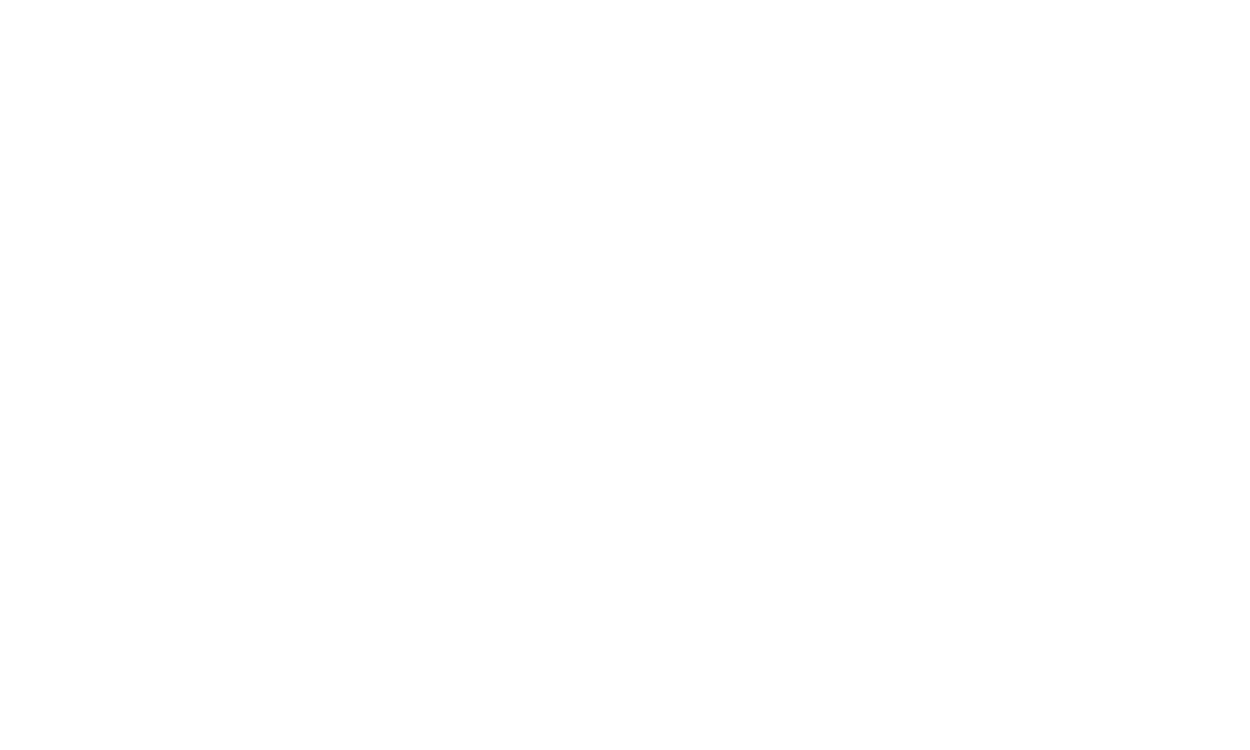

           trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
5835  264.254901  176.300176  236.680359   264.254901   264.254901   
5836  264.253024  166.275017  227.348748   264.253024   264.253024   
5837  264.251147  153.933566  213.135859   264.251147   264.251147   
5838  264.249270  143.254878  200.288220   264.249270   264.249270   
5839  264.247393  132.611674  195.330160   264.247393   264.247393   

      additive_terms  additive_terms_lower  additive_terms_upper      daily  \
5835      -55.601220            -55.601220            -55.601220  23.042836   
5836      -68.293779            -68.293779            -68.293779  10.493126   
5837      -80.877591            -80.877591            -80.877591  -1.913910   
5838      -92.472001            -92.472001            -92.472001 -13.335390   
5839      -99.276805            -99.276805            -99.276805 -20.006560   

      daily_lower  daily_upper     yearly  yearly_lower  yearly_upper  \
5835    23.042836    23.042836 

<IPython.core.display.Javascript object>


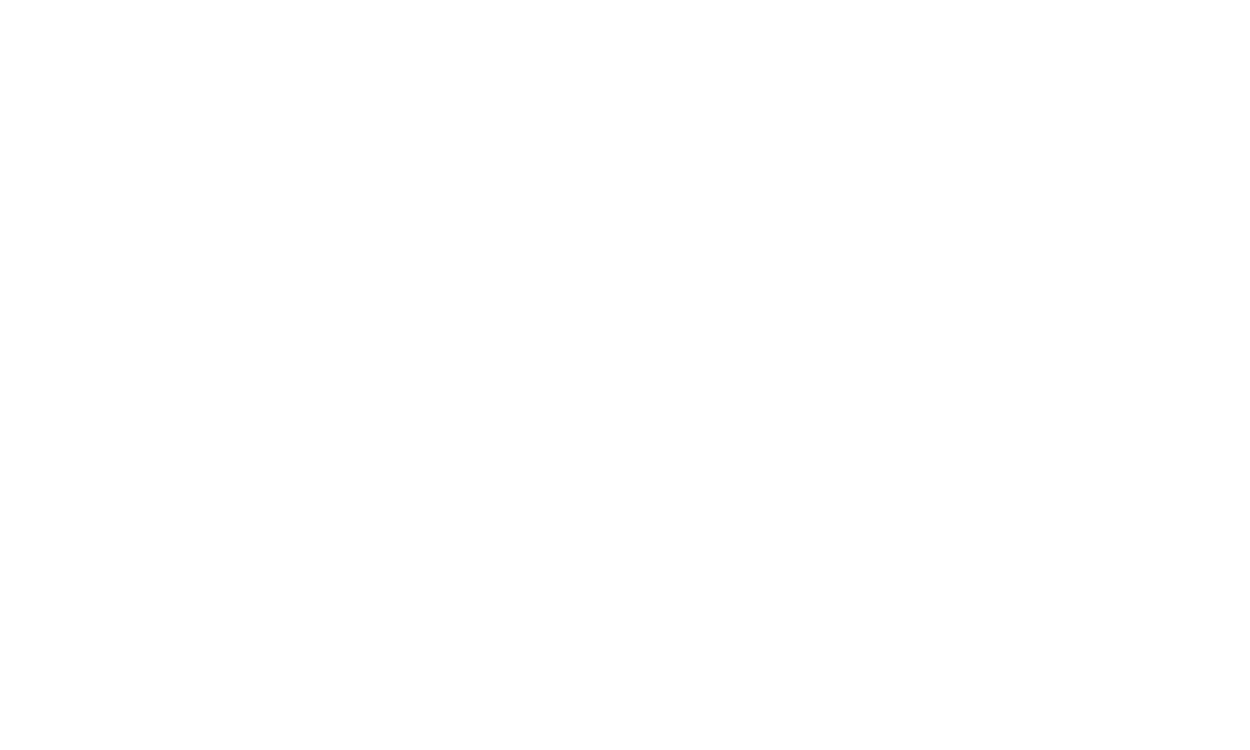

         trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
5835  0.014016   -0.104771    0.112231     0.014016     0.014016   
5836  0.014019   -0.097870    0.115941     0.014019     0.014019   
5837  0.014021   -0.100676    0.109755     0.014021     0.014021   
5838  0.014023   -0.097284    0.120111     0.014023     0.014023   
5839  0.014025   -0.100059    0.115381     0.014025     0.014025   

      additive_terms  additive_terms_lower  additive_terms_upper     daily  \
5835       -0.003689             -0.003689             -0.003689  0.002255   
5836       -0.005402             -0.005402             -0.005402 -0.000970   
5837       -0.004733             -0.004733             -0.004733 -0.001549   
5838       -0.003145             -0.003145             -0.003145 -0.000847   
5839       -0.002560             -0.002560             -0.002560 -0.000723   

      daily_lower  daily_upper    yearly  yearly_lower  yearly_upper      yhat  
5835     0.002255     0.002255 -0.009174 

<IPython.core.display.Javascript object>


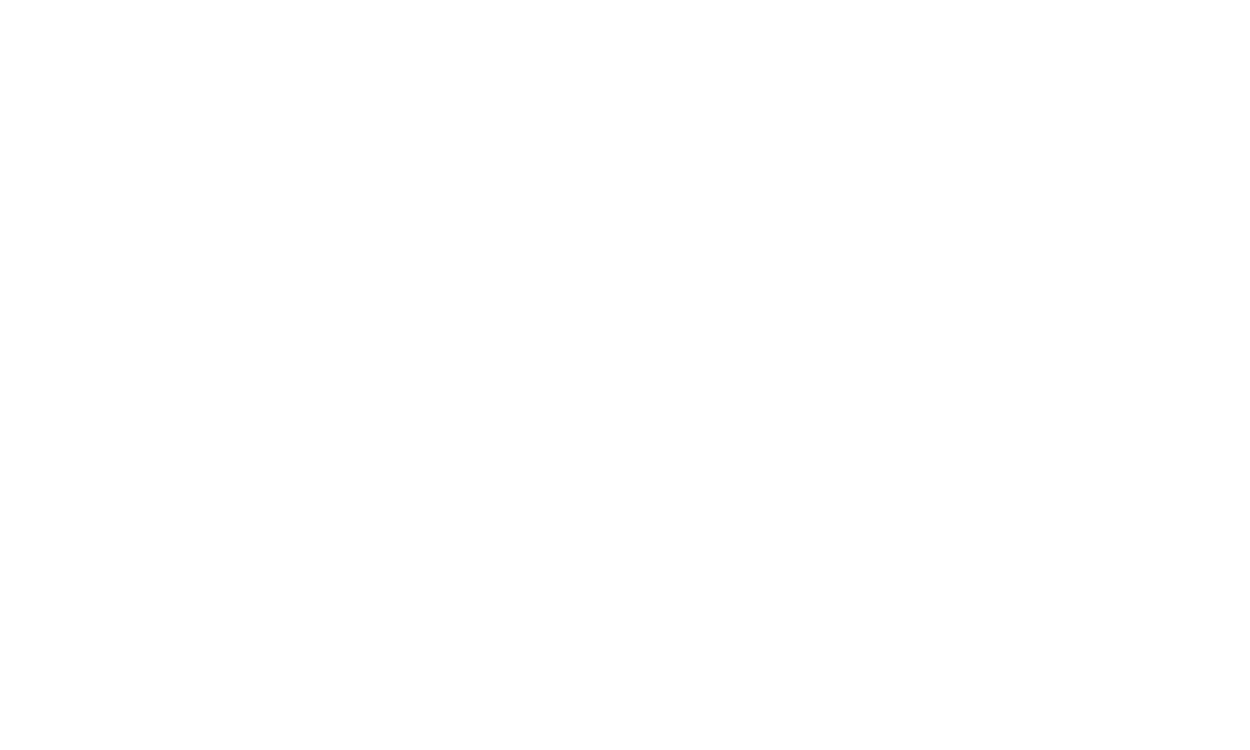

             trend    yhat_lower    yhat_upper   trend_lower   trend_upper  \
5835  85495.353712  85450.620146  86492.116756  85495.353712  85495.353712   
5836  85495.352382  85459.606702  86515.491487  85495.352382  85495.352382   
5837  85495.351052  85504.156294  86512.376347  85495.351052  85495.351052   
5838  85495.349723  85545.321846  86554.743687  85495.349723  85495.349723   
5839  85495.348393  85506.012111  86537.722782  85495.348393  85495.348393   

      additive_terms  additive_terms_lower  additive_terms_upper       daily  \
5835      466.421064            466.421064            466.421064 -105.949694   
5836      489.720369            489.720369            489.720369  -78.984288   
5837      548.194972            548.194972            548.194972  -14.103041   
5838      555.116065            555.116065            555.116065    1.649248   
5839      534.964357            534.964357            534.964357   -7.774693   

      daily_lower  daily_upper      yearly  yearly

<IPython.core.display.Javascript object>


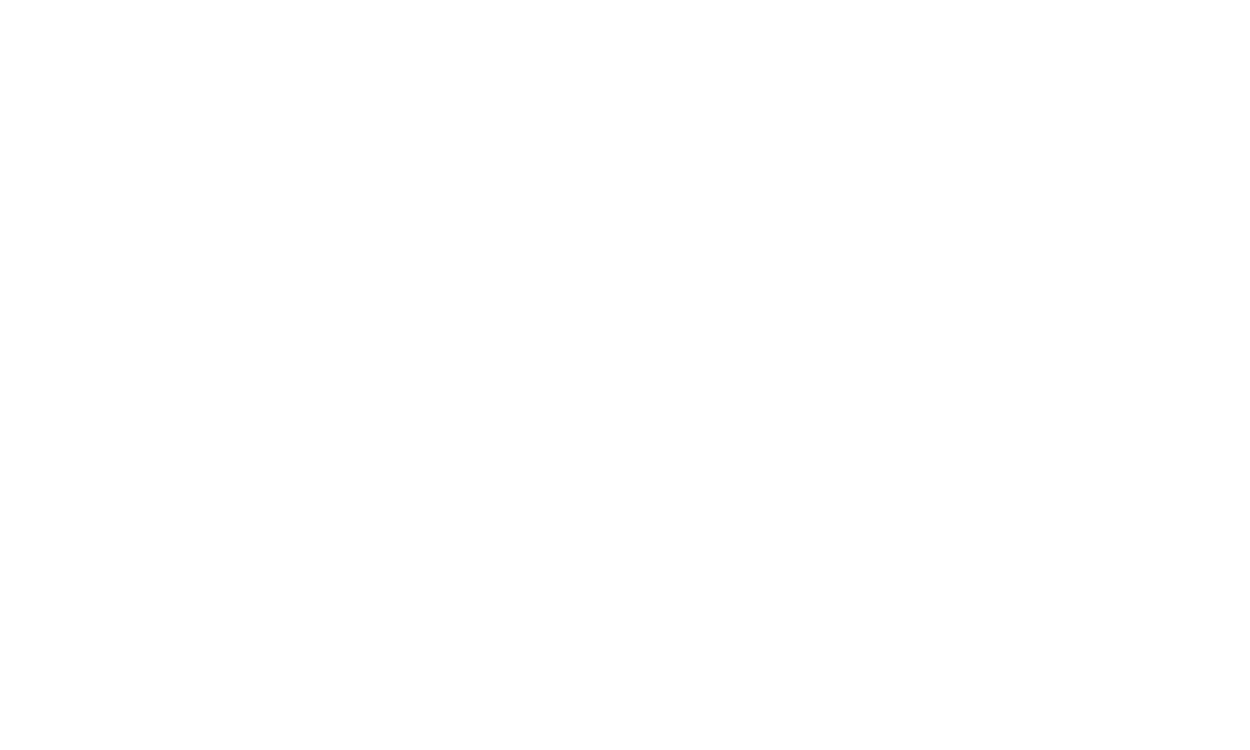

           trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
5835  193.859665  114.154406  387.730936   193.859665   193.859665   
5836  193.859515 -222.317835   66.120251   193.859515   193.859515   
5837  193.859365 -241.733817   35.351933   193.859365   193.859365   
5838  193.859216 -239.081843   38.572393   193.859216   193.859216   
5839  193.859066 -246.323201   28.669979   193.859066   193.859066   

      additive_terms  additive_terms_lower  additive_terms_upper       daily  \
5835       49.265295             49.265295             49.265295  153.131434   
5836     -276.010292           -276.010292           -276.010292 -172.132179   
5837     -296.608638           -296.608638           -296.608638 -192.752968   
5838     -296.575010           -296.575010           -296.575010 -192.754575   
5839     -296.511715           -296.511715           -296.511715 -192.718858   

      daily_lower  daily_upper      yearly  yearly_lower  yearly_upper  \
5835   153.131434   153.

<IPython.core.display.Javascript object>


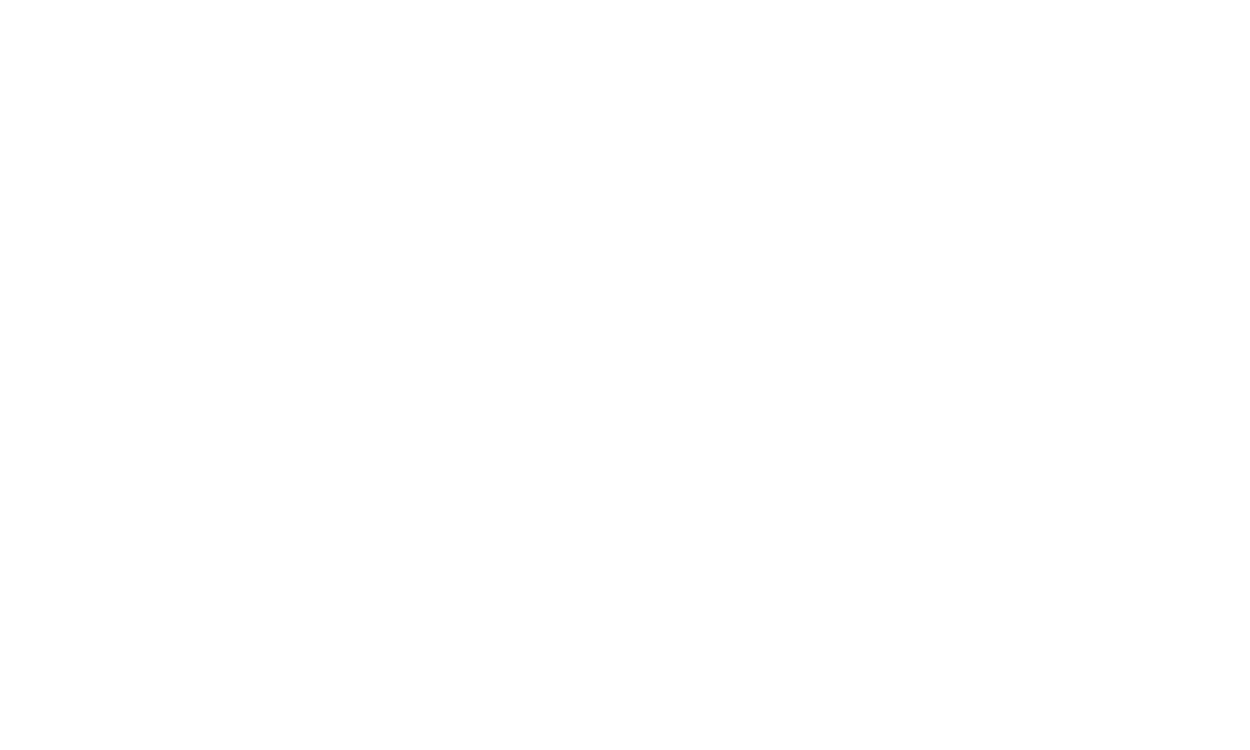

           trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
5835  280.074524  263.406658  272.901831   280.074524   280.074524   
5836  280.073981  259.862613  269.174802   280.073981   280.073981   
5837  280.073438  255.884697  265.965389   280.073438   280.073438   
5838  280.072896  252.787155  262.459813   280.072896   280.072896   
5839  280.072353  250.401270  260.750593   280.072353   280.072353   

      additive_terms  additive_terms_lower  additive_terms_upper     daily  \
5835      -11.935812            -11.935812            -11.935812  6.524491   
5836      -15.635233            -15.635233            -15.635233  2.895866   
5837      -19.300483            -19.300483            -19.300483 -0.705333   
5838      -22.476304            -22.476304            -22.476304 -3.830765   
5839      -24.485227            -24.485227            -24.485227 -5.808263   

      daily_lower  daily_upper     yearly  yearly_lower  yearly_upper  \
5835     6.524491     6.524491 -18.70

<IPython.core.display.Javascript object>


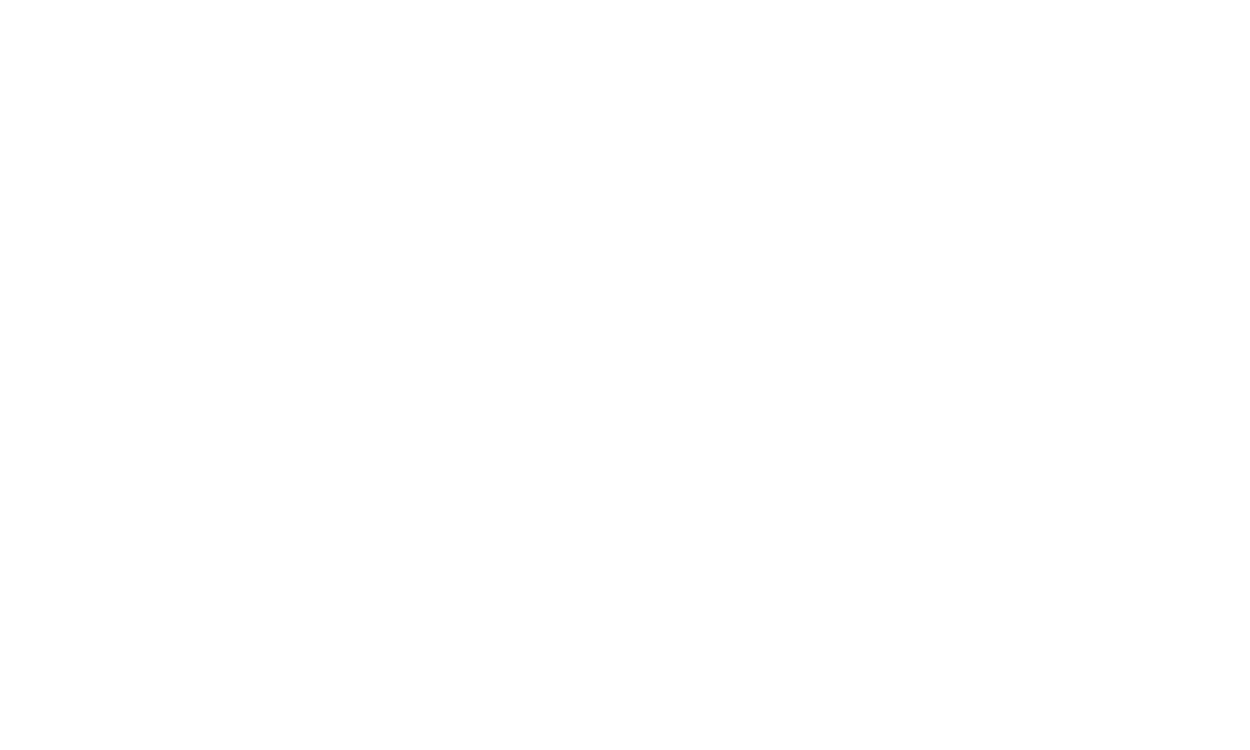

         trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
5835  4.040572    2.533521    8.105432     4.040572     4.040572   
5836  4.040556    1.141002    6.902545     4.040556     4.040556   
5837  4.040540    0.878314    6.626542     4.040540     4.040540   
5838  4.040524    0.664551    6.228565     4.040524     4.040524   
5839  4.040508    0.424585    5.993472     4.040508     4.040508   

      additive_terms  additive_terms_lower  additive_terms_upper     daily  \
5835        1.322562              1.322562              1.322562  1.085305   
5836        0.094858              0.094858              0.094858 -0.086657   
5837       -0.268239             -0.268239             -0.268239 -0.391258   
5838       -0.629281             -0.629281             -0.629281 -0.695977   
5839       -0.851260             -0.851260             -0.851260 -0.868636   

      daily_lower  daily_upper    yearly  yearly_lower  yearly_upper      yhat  
5835     1.085305     1.085305  0.196956 

In [8]:
X=np.empty((data.shape[0],0))
features = ['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms',
        'additive_terms_lower', 'additive_terms_upper', 'daily', 'daily_lower', 'daily_upper',
        'yearly', 'yearly_lower', 'yearly_upper', 'yhat']
for i in range(0, len(IImfs)):
    temp_df = pd.DataFrame(data['ds'])
    temp_df['y'] = IImfs[i]
    m = Prophet(changepoint_prior_scale=1.0, seasonality_prior_scale=0.1, seasonality_mode='additive', changepoint_range=0.2, yearly_seasonality=True)
    m.fit(temp_df)
    future = m.make_future_dataframe(periods=0, freq='3H')
    forecast = m.predict(future)
    X=np.append(X, forecast[features].to_numpy(), axis=1)
    fig1 = m.plot(forecast)
    fig1.show()
    print(forecast[features].tail())

In [9]:
X.shape

(5840, 90)

In [10]:
#split the data into training and testing sets
split_line=4672
X_train = np.array(X[:split_line])
X_test = np.array(X[split_line:])
y_train = np.array(y[:split_line])
y_test = np.array(y[split_line:])

In [11]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [13]:
#define the model structure
model = keras.models.Sequential()
model.add(keras.layers.GRU(1024, input_shape = (1, X_train.shape[1:][1]),
                           activation = 'relu', recurrent_activation = 'relu',
                           return_sequences = True))
model.add(keras.layers.GRU(1024, activation = 'sigmoid', recurrent_activation = 'sigmoid', return_sequences = True))
model.add(keras.layers.GRU(1024, activation = 'tanh', recurrent_activation = 'tanh', return_sequences = True))
model.add(keras.layers.Dense(1))

In [14]:
#define the hyperparameters for fitting the data to the model keras.optimizers.Adam(0.001)
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Nadam(0.001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 1024)           3428352   
                                                                 
 gru_1 (GRU)                 (None, 1, 1024)           6297600   
                                                                 
 gru_2 (GRU)                 (None, 1, 1024)           6297600   
                                                                 
 dense (Dense)               (None, 1, 1)              1025      
                                                                 
Total params: 16,024,577
Trainable params: 16,024,577
Non-trainable params: 0
_________________________________________________________________


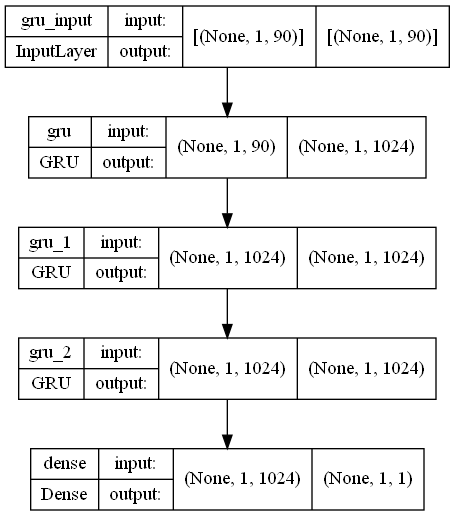

In [15]:
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
#callback function to stop running epochs when the error does not improve by a specified amount
es_callback = keras.callbacks.EarlyStopping(patience = 150, restore_best_weights = True)

In [17]:
#fit the model
history = model.fit(X_train, y_train, validation_split = 0.1, epochs = 10000, verbose = 1, shuffle = True,
                    callbacks = [es_callback])
#history = model.fit(X_train, y_train, epochs = 200, verbose = 1, shuffle = True)

Epoch 1/10000
132/132 [==============================] - 51s 368ms/step - loss: 6.3487 - val_loss: 4.7775
Epoch 2/10000
132/132 [==============================] - 48s 366ms/step - loss: 5.2735 - val_loss: 4.6787
Epoch 3/10000
132/132 [==============================] - 48s 367ms/step - loss: 5.1260 - val_loss: 4.1082
Epoch 4/10000
132/132 [==============================] - 48s 362ms/step - loss: 5.1387 - val_loss: 5.2773
Epoch 5/10000
132/132 [==============================] - 48s 363ms/step - loss: 5.0559 - val_loss: 4.0112
Epoch 6/10000
132/132 [==============================] - 48s 366ms/step - loss: 5.0017 - val_loss: 3.9917
Epoch 7/10000
132/132 [==============================] - 61s 460ms/step - loss: 4.9675 - val_loss: 3.9691
Epoch 8/10000
132/132 [==============================] - 60s 455ms/step - loss: 4.9713 - val_loss: 4.4587
Epoch 9/10000
132/132 [==============================] - 59s 451ms/step - loss: 4.9578 - val_loss: 3.9794
Epoch 10/10000
132/132 [======================

132/132 [==============================] - 59s 448ms/step - loss: 4.1005 - val_loss: 4.2381
Epoch 154/10000
132/132 [==============================] - 62s 471ms/step - loss: 4.1031 - val_loss: 4.2385
Epoch 155/10000
132/132 [==============================] - 61s 460ms/step - loss: 4.0774 - val_loss: 4.1427
Epoch 156/10000
132/132 [==============================] - 59s 449ms/step - loss: 4.1541 - val_loss: 4.2586
Epoch 157/10000
132/132 [==============================] - 59s 446ms/step - loss: 4.0880 - val_loss: 4.3143
Epoch 158/10000
132/132 [==============================] - 59s 444ms/step - loss: 4.0838 - val_loss: 4.1580
Epoch 159/10000
132/132 [==============================] - 59s 445ms/step - loss: 4.0690 - val_loss: 4.1154
Epoch 160/10000
132/132 [==============================] - 59s 447ms/step - loss: 3.9940 - val_loss: 4.2894
Epoch 161/10000
132/132 [==============================] - 58s 443ms/step - loss: 4.0076 - val_loss: 4.3897
Epoch 162/10000
132/132 [===================

In [18]:
#make predictions
predictions = model.predict(X_test)
predictions = predictions.flatten()
print_metrics(predictions[:-1], y_test)

mae:  1.611261314306715
mse:  4.565466254313983
rmse:  2.136695171126191
score:  0.09067162052270628
accuracy:  0.30077120822622105


In [19]:
#print training error for checking over-fitting
mse_train = metrics.mean_absolute_percentage_error((model.predict(X_train)).flatten(), y_train)
print('train mape: ', mse_train)

train mse:  4.6942235475542216


<IPython.core.display.Javascript object>


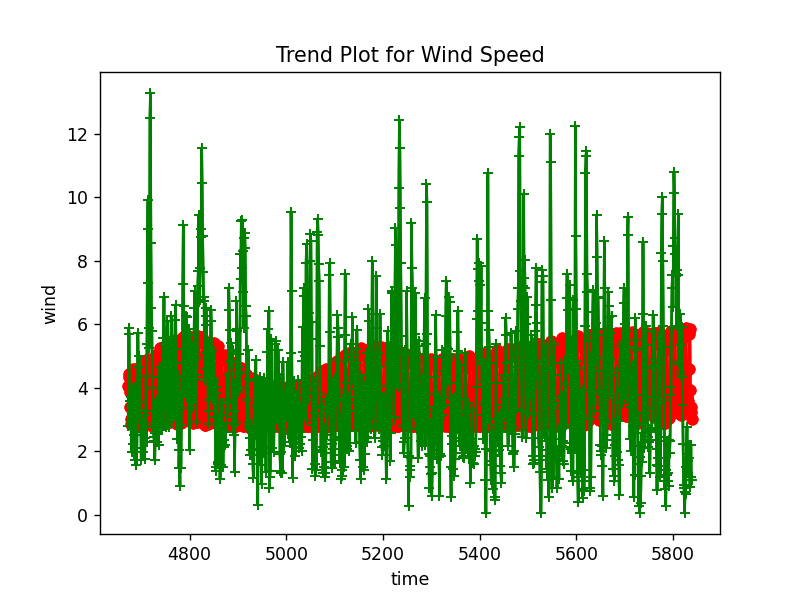

In [20]:
import matplotlib.pyplot as plt
%matplotlib notebook
x1=x2=data[["ds"]][1:][split_line:].index
y1=predictions[:-1]
y2=y_test
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
plt.title('Trend Plot for Wind Speed')
l1=plt.plot(x1,y1,'ro-',label='predict')
l2=plt.plot(x2,y2,'g+-',label='real')
plt.xlabel('time')
plt.ylabel('wind')
plt.show()